In [150]:
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cv2

def hog_p(img):
    img = np.array(img, dtype=np.int64) 

    mag = []
    theta = []
    for i in range(28):
        magnitudeArray = []
        angleArray = []
        for j in range(28):
            # Condition for axis 0
            if j-1 <= 0 or j+1 >= 28:
                if j-1 <= 0:
                    # Condition if first element
                    Gx = img[i][j+1] - 0
                elif j + 1 >= len(img[0]):
                    Gx = 0 - img[i][j-1]
            # Condition for first element
            else:
                Gx = img[i][j+1] - img[i][j-1]

            # Condition for axis 1
            if i-1 <= 0 or i+1 >= 28:
                if i-1 <= 0:
                    Gy = 0 - img[i+1][j]
                elif i + 1 >= 28:
                    Gy = img[i-1][j] - 0
            else:
                Gy = img[i-1][j] - img[i+1][j]

            # Calcula la magnitud
            magnitude = math.sqrt(pow(Gx, 2) + pow(Gy, 2))
            # Asegura que la magnitud esté dentro del rango válido de int64
            magnitude = min(magnitude, np.iinfo(np.int64).max)
            magnitudeArray.append(round(magnitude, 9))

            # Calculating angle
            if Gx == 0:
                angle = math.degrees(0.0)
            else:
                angle = abs(math.degrees(math.atan(Gy / Gx)))
            angle = min(angle, np.iinfo(np.int64).max)
            angleArray.append(round(angle, 9))
        mag.append(magnitudeArray)
        theta.append(angleArray)

    mag = np.array(mag)  
    theta = np.array(theta)

    # plt.figure(figsize=(15, 8))
    # plt.imshow(mag, cmap="gray")
    # plt.axis("off")
    # plt.show()


    # plt.figure(figsize=(15, 8))
    # plt.imshow(theta, cmap="gray")
    # plt.axis("off")
    # plt.show()

    # Tamaño de la celda en píxeles (por lo general, 8x8)
    cell_size = 8

    # Número de celdas en el eje X e Y
    cells_x = len(mag[0]) // cell_size
    cells_y = len(mag) // cell_size

    # Número de orientaciones en el histograma (por lo general, 9)
    num_bins = 9

    # Inicializar histogramas
    histograms = np.zeros((cells_y, cells_x, num_bins), dtype=np.float32)

    # Rango de ángulos de orientación (de 0 a 180 grados)
    angle_range = 180

    # Calcular el ancho de cada bin del histograma
    bin_width = angle_range / num_bins

    # Para cada celda
    for y in range(cells_y):
        for x in range(cells_x):
            # Obtener las magnitudes y orientaciones en la celda
            cell_magnitudes = mag[y * cell_size:(y + 1) * cell_size, x * cell_size:(x + 1) * cell_size]
            cell_angles = theta[y * cell_size:(y + 1) * cell_size, x * cell_size:(x + 1) * cell_size]

            # Calcular histograma de orientación de gradientes para la celda
            for i in range(cell_size):
                for j in range(cell_size):
                    angle = cell_angles[i, j]
                    magnitude = cell_magnitudes[i, j]

                    # Calcular a qué bin pertenece el ángulo
                    bin_index = int(angle / bin_width)

                    # Distribuir la magnitud en los bins adyacentes (interpolación lineal)
                    if bin_index < num_bins - 1:
                        histograms[y, x, bin_index] += magnitude * (1 - (angle % bin_width) / bin_width)
                        histograms[y, x, bin_index + 1] += magnitude * (angle % bin_width) / bin_width
                    else:
                        histograms[y, x, bin_index] += magnitude

    # Normalizar bloques de celdas
    block_size = 2  # Tamaño del bloque en celdas (por lo general, 2x2)
    block_stride = 1  # Desplazamiento del bloque en celdas (por lo general, 1 celda)
    norm_type = cv2.NORM_L2
    epsilon = 1e-4

    # Inicializar vectores de características HOG
    hog_features = []

    # Para cada bloque de celdas
    for y in range(cells_y - block_size + 1):
        for x in range(cells_x - block_size + 1):
            block = histograms[y:y + block_size, x:x + block_size, :]

            # Calcular la norma del bloque
            block_norm = np.sqrt(np.sum(block ** 2) + epsilon ** 2)

            # Normalizar el bloque y aplanar en un vector de características
            block /= block_norm
            hog_features.extend(block.flatten())
            
    return hog_features

In [151]:
def loadDataset(fileName, samples):
    x = []
    y = []
    train_data = pd.read_csv(fileName)
    y = np.array(train_data.iloc[0:samples, 0])
    x = np.array(train_data.iloc[0:samples, 1:])
    return x,y
 
x,y=loadDataset("Nmist/mnist_test.csv",10000)


data = []

for i in range(len(x)):
    digit_pixels = x[i].reshape(28, 28)
    digit_pixels = digit_pixels.astype(np.uint8)
    features = hog_p(digit_pixels)
    label = y[i]
    data.append(list(features) + [label])

columns = [f'HOG_{i}' for i in range(len(features))] + ['Label']
df = pd.DataFrame(data, columns=columns)
df.to_csv('HOG.csv', index=False)
df



,HOG_0,HOG_1,HOG_2,HOG_3,HOG_4,HOG_5,HOG_6,HOG_7,HOG_8,HOG_9,...,HOG_135,HOG_136,HOG_137,HOG_138,HOG_139,HOG_140,HOG_141,HOG_142,HOG_143,Label
0,0.044355,0.077999,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.282530,...,0.616511,0.000000,0.000000,0.479712,0.605334,0.152846,0.0,0.0,0.0,2
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.063882,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.239314,...,0.184936,0.270613,0.762480,0.549731,0.094700,0.004408,0.0,0.0,0.0,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.296683,...,0.910106,0.376283,0.135031,0.106028,0.025337,0.000000,0.0,0.0,0.0,4
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.033407,...,0.999981,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0.027305,0.040613,0.066699,0.089482,0.000000,0.000000,0.0,0.0,0.0,0.503012,...,0.888344,0.080104,0.130438,0.364935,0.232888,0.000000,0.0,0.0,0.0,2
9995,0.028249,0.128593,0.055745,0.028913,0.028922,0.009876,0.0,0.0,0.0,0.264509,...,0.622970,0.275291,0.643412,0.345804,0.050501,0.003674,0.0,0.0,0.0,3
9996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.168917,...,0.174692,0.374659,0.692404,0.503664,0.305745,0.050299,0.0,0.0,0.0,4
9997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.024541,...,0.637894,0.650262,0.399036,0.104974,0.000000,0.000000,0.0,0.0,0.0,5


In [152]:
from sklearn.model_selection import train_test_split

X = df.drop('Label', axis=1)
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)  # Puedes ajustar el valor de k

# Entrenar el modelo con los datos de entrenamiento
knn.fit(X_train, y_train)
# Predecir etiquetas en el conjunto de prueba
y_pred = knn.predict(X_test)

# Evaluar el rendimiento del modelo (por ejemplo, utilizando la precisión)
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Precisión del modelo: {accuracy}')
print(report)



Precisión del modelo: 0.8755
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       205
           1       0.96      0.97      0.97       218
           2       0.91      0.85      0.88       192
           3       0.79      0.88      0.83       201
           4       0.90      0.76      0.83       205
           5       0.95      0.82      0.88       198
           6       0.92      0.98      0.95       186
           7       0.91      0.83      0.87       193
           8       0.79      0.84      0.82       191
           9       0.78      0.87      0.82       211

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



In [154]:
import numpy as np
import pandas as pd


def divide(X, y):
    test_size = 0.2
    random_state = 42
    total_samples = len(X)
    test_samples = int(total_samples * test_size)
    np.random.seed(random_state)
    test_indices = np.random.choice(total_samples, test_samples, replace=False)
    train_indices = np.array(list(set(range(total_samples)) - set(test_indices)))
    X_train = X.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_indices]
    return X_train, X_test, y_train, y_test

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def predict_knn(X_train, y_train, x_test, k):
    distances = [euclidean_distance(x_test, x) for x in X_train]
    k_indices = np.argsort(distances)[:k]
    k_nearest_labels = [y_train[i] for i in k_indices]
    most_common = np.bincount(k_nearest_labels).argmax()
    return most_common

def knn(X_train, y_train, X_test, k):
    predictions = [predict_knn(X_train, y_train, x, k) for x in X_test]
    return predictions

X = df.drop('Label', axis=1)
y = df['Label']

X_train, X_test, y_train, y_test = divide(X, y)

k = 5
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

y_pred = knn(X_train, y_train, X_test, k)

accuracy = np.mean(y_pred == y_test)
print(f'Precisión del modelo k-NN con k={k}: {accuracy * 100:.2f}%')

from sklearn.metrics import confusion_matrix
def precision_per_class(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    precision = cm.diagonal() / cm.sum(axis=0)
    return precision

# Uso de la función precision_per_class
precision_scores = precision_per_class(y_test, y_pred)

for label, precision in enumerate(precision_scores):
    print(f'Precision for class {label}: {precision * 100:.2f}%')



Precisión del modelo k-NN con k=5: 87.54%
Precision for class 0: 88.99%
Precision for class 1: 96.36%
Precision for class 2: 90.56%
Precision for class 3: 78.67%
Precision for class 4: 90.17%
Precision for class 5: 95.29%
Precision for class 6: 91.96%
Precision for class 7: 90.91%
Precision for class 8: 78.82%
Precision for class 9: 77.87%


In [155]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.svm import SVC as SVM
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestCentroid as NC
from sklearn.model_selection import train_test_split as data_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

classifiers = {
	# "NC"         : NC(),
	#"LDA"        : LDA(),
	# "QDA"        : QDA(),
	#"SVM_linear" : SVM(kernel="linear"),
	 "SVM_radial" : SVM(kernel="rbf")
}

def classification(data_file, rounds=100, remove_disperse=[]):
	df_copy = data_file.copy() 
	
	if remove_disperse:
		df_copy = df_copy.drop(remove_disperse, axis=1)
	
	X = df_copy.drop('Label', axis=1)
	y = df_copy['Label']
	
	ans = {key: {"score" : []} for key, value in classifiers.items()}
	
	print("Classifying...")
	
	for i in range(rounds):
		X_train, X_test, y_train, y_test = data_split(X, y, test_size=0.2)
		
		for name, classifier in classifiers.items():
			scaler = StandardScaler()
			scaler.fit(X_train)
			X_train = scaler.transform(X_train)
			X_test = scaler.transform(X_test)
			
			classifier.fit(X_train, y_train)
			score = classifier.score(X_test, y_test)
			
			ans[name]["score"].append(score)
		
	print("Classification done!")
	
	return ans

ans = classification(df)

def sumary(ans, title="Summary"):
	size = 70
	separator = "-"
	
	print(separator*size)
	print("SUMARY: {}".format(title))
	print(separator*size)
	print("CLASSIF\t\tMEAN\tMEDIAN\tMINV\tMAXV\tSTD")
	print(separator*size)
	
	for n in ans:
		m = round(np.mean(ans[n]["score"])*100, 2)
		med = round(np.median(ans[n]["score"])*100, 2)
		minv = round(np.min(ans[n]["score"])*100, 2)
		maxv = round(np.max(ans[n]["score"])*100, 2)
		std = round(np.std(ans[n]["score"])*100, 2)
		
		print("{:<16}{}\t{}\t{}\t{}\t{}".format(n, m, med, minv, maxv, std))
	
	print(separator*size)
	print()

sumary(ans)

Classifying...
Classification done!
----------------------------------------------------------------------
SUMARY: Summary
----------------------------------------------------------------------
CLASSIF		MEAN	MEDIAN	MINV	MAXV	STD
----------------------------------------------------------------------
SVM_radial      91.72	91.75	90.15	93.1	0.57
----------------------------------------------------------------------



In [156]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.svm import SVC as SVM
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestCentroid as NC
from sklearn.model_selection import train_test_split as data_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

classifiers = {
	# "NC"         : NC(),
	#"LDA"        : LDA(),
	# "QDA"        : QDA(),
	"SVM_linear" : SVM(kernel="linear"),
	#"SVM_radial" : SVM(kernel="rbf")
}

def classification(data_file, rounds=100, remove_disperse=[]):
	df_copy = data_file.copy() 
	
	if remove_disperse:
		df_copy = df_copy.drop(remove_disperse, axis=1)
	
	X = df_copy.drop('Label', axis=1)
	y = df_copy['Label']
	
	ans = {key: {"score" : []} for key, value in classifiers.items()}
	
	print("Classifying...")
	
	for i in range(rounds):
		X_train, X_test, y_train, y_test = data_split(X, y, test_size=0.2)
		
		for name, classifier in classifiers.items():
			scaler = StandardScaler()
			scaler.fit(X_train)
			X_train = scaler.transform(X_train)
			X_test = scaler.transform(X_test)
			
			classifier.fit(X_train, y_train)
			score = classifier.score(X_test, y_test)
			
			ans[name]["score"].append(score)
		
	print("Classification done!")
	
	return ans

ans = classification(df)

def sumary(ans, title="Summary"):
	size = 70
	separator = "-"
	
	print(separator*size)
	print("SUMARY: {}".format(title))
	print(separator*size)
	print("CLASSIF\t\tMEAN\tMEDIAN\tMINV\tMAXV\tSTD")
	print(separator*size)
	
	for n in ans:
		m = round(np.mean(ans[n]["score"])*100, 2)
		med = round(np.median(ans[n]["score"])*100, 2)
		minv = round(np.min(ans[n]["score"])*100, 2)
		maxv = round(np.max(ans[n]["score"])*100, 2)
		std = round(np.std(ans[n]["score"])*100, 2)
		
		print("{:<16}{}\t{}\t{}\t{}\t{}".format(n, m, med, minv, maxv, std))
	
	print(separator*size)
	print()

sumary(ans)

Classifying...
Classification done!
----------------------------------------------------------------------
SUMARY: Summary
----------------------------------------------------------------------
CLASSIF		MEAN	MEDIAN	MINV	MAXV	STD
----------------------------------------------------------------------
SVM_linear      89.64	89.6	88.05	91.25	0.58
----------------------------------------------------------------------



2
[0.044355225, 0.07799856, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2825295, 0.081891544, 0.32147074, 0.41594237, 0.2276209, 0.01352049, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0073541617, 0.0049751187, 0.0, 0.0, 0.0, 0.0, 0.09278683, 0.3735146, 0.64658004, 0.08631226, 0.056310657, 0.013647942, 0.0, 0.0, 0.0, 0.00016519632, 4.7882368e-05, 0.00018796544, 0.00024320344, 0.000133091, 7.9054935e-06, 0.0, 0.0, 0.0, 0.5170358, 0.5805834, 0.25634703, 0.11967327, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4252894e-05, 0.00021839573, 0.00037805835, 5.046718e-05, 3.2925105e-05, 7.980016e-06, 0.0, 0.0, 0.0, 0.16216947, 0.40683153, 0.35174087, 0.0053483187, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3046949e-06, 8.826312e-07, 0.0, 0.0, 0.0, 0.0, 9.624955e-09, 3.8745384e-08, 6.707098e-08, 8.953336e-09, 5.8412124e-09, 1.4157271e-09, 0.0, 0.0, 0.0, 0.19000511, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8183275, 0.1827838, 0.40941653, 0.2265106, 0.19936632, 0.04639433, 0.0, 0.0, 0.0, 2.2919637e-12, 9.226331e-12, 1.5971426e-11, 2.

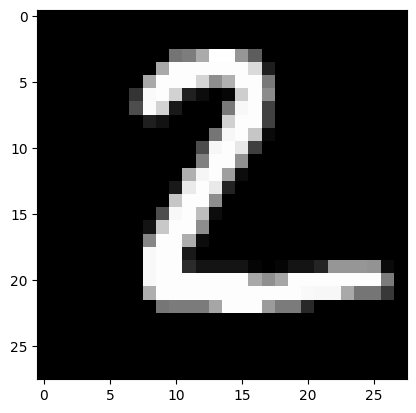

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def loadDataset(fileName, samples):
    x = []
    y = []
    train_data = pd.read_csv(fileName)
    y = np.array(train_data.iloc[0:samples, 0])
    x = np.array(train_data.iloc[0:samples, 1:])
    return x,y
 
x,y=loadDataset("Nmist/mnist_test.csv",500)

digit = x[0]
label = y[0]
print(label)
digit_pixels = digit.reshape(28, 28)
digit_pixels = digit_pixels.astype(np.uint8)

features = hog_p(digit_pixels)
print(features)
plt.imshow(digit_pixels, cmap='gray')
plt.show()

[0.0059515233, 0.0006690988, 0.006907714, 0.011298051, 0.018589897, 0.0, 0.0, 0.0, 0.0, 0.028675523, 0.0, 0.0, 0.009420289, 0.12677312, 0.039479397, 0.0, 0.0, 0.0, 0.393285, 0.24426277, 0.09282372, 0.009025088, 0.0, 0.0, 0.0, 0.0, 0.0, 0.30891538, 0.09510436, 0.36265844, 0.67103666, 0.26629886, 0.02582587, 0.0, 0.0, 0.0, 6.128627e-06, 0.0, 0.0, 2.013335e-06, 2.7094367e-05, 8.437667e-06, 0.0, 0.0, 0.0, 0.02008999, 0.008118826, 0.0019284425, 0.018899981, 0.08968602, 0.00033771704, 0.0, 0.0, 0.0, 6.602241e-05, 2.0326017e-05, 7.750856e-05, 0.00014341617, 5.691427e-05, 5.5195896e-06, 0.0, 0.0, 0.0, 0.19423848, 0.30444425, 0.66746646, 0.6158348, 0.18870914, 0.018326228, 0.0, 0.0, 0.0, 0.00011035277, 6.853827e-05, 2.6045627e-05, 2.5323707e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 1.8525384e-08, 5.703325e-09, 2.174831e-08, 4.024148e-08, 1.5969709e-08, 1.5487547e-09, 0.0, 0.0, 0.0, 0.5501527, 0.4626656, 0.023173818, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5845073, 0.37528098, 0.015826631, 0.0005196652, 0.000107758

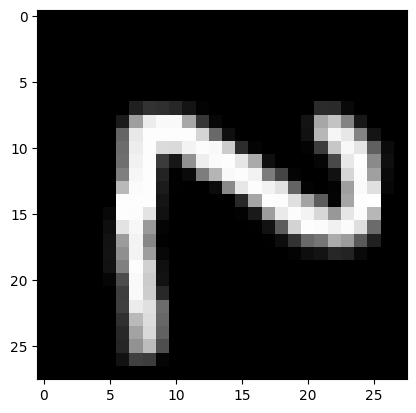

In [158]:
def rotar(imagen, angulo_rotacion):
    alto, ancho = imagen.shape[:2]
    centro = (ancho // 2, alto // 2)
    matriz_rotacion = cv2.getRotationMatrix2D(centro, angulo_rotacion, 1.0)
    imagen_rotada = cv2.warpAffine(imagen, matriz_rotacion, (ancho, alto))
    return imagen_rotada

angulo_rotacion = 268
img = rotar(digit_pixels, angulo_rotacion)
plt.imshow(img, cmap='gray')

features = hog_p(img)
print(features)

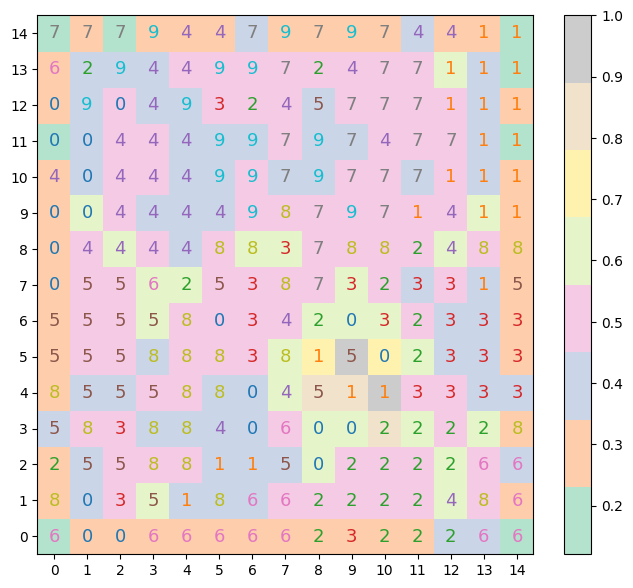

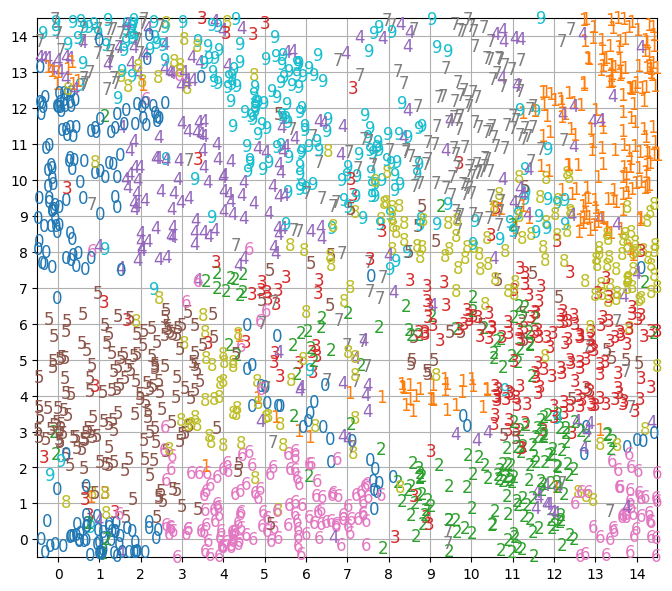

In [170]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


X = df.drop('Label', axis=1)
y = df['Label']

# Normalizar los datos
normalizador = MinMaxScaler(feature_range=(0, 1))
x_train = normalizador.fit_transform(X_train)
x_test = normalizador.transform(X_test)

som = MiniSom(x=15, y=15, input_len=144, sigma=1, learning_rate=0.5, random_seed=2)
som.random_weights_init(x_train)
som.train_random(data=x_train, num_iteration=5000)

# Mapeo de activación
q_train = som.activation_response(x_train)

# Gráfico mejorado del SOM con etiquetas de entrenamiento
winners_train = np.array([som.winner(x) for x in x_train])
grid_size = som.get_weights().shape

# Crear una matriz para almacenar las etiquetas de clase correspondientes a las neuronas ganadoras
class_labels_train = np.zeros((grid_size[0], grid_size[1]), dtype=int)

for i, (x_, y_) in enumerate(winners_train):
    class_labels_train[x_, y_] = y_train[i]

plt.figure(figsize=(8, 7))
plt.pcolor(som.distance_map().T, cmap='Pastel2')
plt.colorbar()

for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        plt.text(i + 0.5, j + 0.5, str(class_labels_train[i, j]),
                 color='C' + str(class_labels_train[i, j]),
                 fontsize=13, ha='center', va='center')

plt.xticks(np.arange(0.5, grid_size[0], 1), range(grid_size[0]))
plt.yticks(np.arange(0.5, grid_size[1], 1), range(grid_size[1]))

plt.show()

# Gráfico del SOM con etiquetas de prueba
winners_test = np.array([som.winner(x) for x in x_test])

plt.figure(figsize=(8, 7))
for i in range(len(x_test)):
    plt.text(winners_test[i][0] + np.random.rand(), winners_test[i][1] + np.random.rand(), str(y_test[i]),
             color='C' + str(y_test[i]), fontsize=12, ha='center', va='center')

plt.xlim(0, grid_size[0])
plt.ylim(0, grid_size[1])
plt.xticks(np.arange(0.5, grid_size[0], 1), range(grid_size[0]))
plt.yticks(np.arange(0.5, grid_size[1], 1), range(grid_size[1]))
plt.grid()
plt.show()
